In [1]:
%matplotlib inline
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

import bpy
import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable
import quat_math
import pickle
import glob

from PIL import Image
import scipy.io as scio
from functools import partial
from object_pose_utils.utils import to_np, to_var
from object_pose_utils.utils.display import *

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import warnings
warnings.filterwarnings('ignore')

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


## Dataset Information

In [2]:
dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'

non_sym_objs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18,]
sym_objs = [13, 16, 19, 20, 21]
textureless_objects = set([10, 11, 13, 14, 16, 19, 20, 21])
textured_objects = set(range(1,22)) - set([10, 11, 13, 14, 16, 19, 20, 21])


with open('{0}/image_sets/classes.txt'.format(dataset_root)) as f:                                    
    classes = f.read().split()
classes.insert(0, '__background__')

In [3]:
def recursiveUpdate(dict_base, dict_new):
    for k,v in dict_new.items():
        if(k in dict_base):
            dict_base[k].update(v)
        else:
            dict_base[k] = v

def updateResults(results_dict, new_results_filename):
    new_data = np.load(new_results_filename, allow_pickle=True)
    new_results = {k:v.item() for k,v in new_data.items()}
    recursiveUpdate(results_dict, new_results)

In [4]:
from object_pose_utils.utils.pose_error import accuracyAUC

def non_func(x):
    return x

def mean_abs(x):
    return np.mean(np.abs(x))

def log_clean(x):
    return np.log(np.maximum(1e-6, x))

def mean_log_clean(x):
    return np.mean(log_clean(x))

def mean_log(x):
    return np.mean(np.log(x))   

def accuracyAUC100(x, max_theshold):
    return accuracyAUC(x, max_theshold)*100

def median_log(x):
    return np.median(np.log(x))

def makeTableEntries(data_dict, keys = None, objs = list(range(1,22)), 
              val_func = non_func, bold_func = max,
              individual = False,
              agg_title = 'All'):
    if(keys is None):
        keys = list(data_dict.keys())
    
    data_str = ''
    if(individual):
        for obj in objs:    
            data_str += ' '.join(classes[obj].split('_')[1:]) + '\n'
            vals = [val_func(np.array(data_dict[k][obj])) for k in keys]
            bold_val = bold_func(vals)
            for v in vals:
                if(v == bold_val):
                    data_str += ' & \\textbf{' + '{:0.2f}'.format(v) + '}'
                else:
                    data_str += ' & {:0.2f}'.format(v)
            data_str += ' \\\\'
            data_str += '\n'

        data_str += '\hline\n'

    data_str += '{} \n'.format(agg_title)
    vals = [val_func(np.concatenate([np.array(data_dict[k][o]) for o in objs])) for k in keys]
    bold_val = bold_func(vals)
    for v in vals:
        if(v == bold_val):
            data_str += ' & \\textbf{' + '{:0.2f}'.format(v) + '}'
        else:
            data_str += ' & {:0.2f}'.format(v)
    data_str += ' \\\\'
    data_str += '\n'
    #print(data_str)
    return data_str
    
def makeTableHeading(names, heading = None):
    data_str = ''
    data_str +='\\begin{table*}[h!]\n'
    data_str +='\\small\n'
    data_str +='\\centering\n'
    data_str +='\\begin{tabular} {||c||' + len(names)*'c|' +'|}\n'
    data_str +='\\hline\n'
        
    data_str += ' '
    if(heading is not None):
        data_str += heading
    else:
        for k in names:
            data_str += ' & ' + k
        data_str += '\\\\'
    data_str += '\n'

    data_str += '\hline\n'
    
    #print(data_str)
    return data_str

def makeTableEnding(caption = None, label = None):
    data_str = ''
    data_str +='\\hline\n'
    data_str +='\\end{tabular}\n'
    if(caption is not None):
        data_str +='\\caption{' + caption + '}\n'
    if(label is not None):
        data_str +='\\label{tbl:' + label + '}\n'
    data_str +='\\end{table*}\n'
    #print(data_str)
    return data_str

In [5]:
results_keys = ['likelihood', 'sym_angular_error_mode', 'add_error_mode', 'add_sym_error_mode']

###################
### DenseFusion ###
###################

df_algorithm_keys = ['bing_iso',
                     #'bing_duel',
                     'hist_comp_global', 
                     'hist_uniform',
                     'bing_fixed',
                     'bing_dropout',
                     'hist_conf', 
                     'hist_cosine', 
                     #'bing_mixed',
                     'hist_reg_global', 
                    ]

df_results = {}

for fn in glob.glob('ral_results/indiv_new/df_*'):
    updateResults(df_results, fn)
    
for res_k, res_v in df_results.items():
    for alg_k, alg_v in res_v.items():
        for k, v in alg_v.items():
            if(type(v) is dict):
                df_results[res_k][alg_k][k] = list(v.values())

for res_k in df_results.keys():
    for alg_k in df_algorithm_keys:
        if(alg_k not in df_results[res_k].keys()):
            df_results[res_k][alg_k] = {}
            for k in range(1,22):
                df_results[res_k][alg_k][k] = [np.nan]
                
###############                
### PoseCNN ###
###############

pc_algorithm_keys = ['bing_iso',
                     #'bing_duel',
                     'hist_comp_fc6', 
                     'hist_uniform',
                     'bing_fixed',
                     'bing_dropout',
                     'hist_conf', 
                     'hist_cosine', 
                     #'bing_mixed',
                     'hist_reg_fc6', 
                     ]

pc_results = {}

for fn in glob.glob('ral_results/indiv_new/pcnn_*'):
    updateResults(pc_results, fn)
                
for res_k, res_v in pc_results.items():
    for alg_k, alg_v in res_v.items():
        for k, v in alg_v.items():
            if(type(v) is dict):
                pc_results[res_k][alg_k][k] = list(v.values())

for res_k in pc_results.keys():
    for alg_k in pc_algorithm_keys:
        if(alg_k not in pc_results[res_k].keys()):
            pc_results[res_k][alg_k] = {}
            for k in range(1,22):
                pc_results[res_k][alg_k][k] = [np.nan]

In [6]:
if(False):
    for fn in glob.glob('ral_results/*_results.npz', recursive=True):
        try:
            data = np.load(fn, allow_pickle=True)
            test_results = {'likelihood':data['likelihood'].item()}
            #updateResults(test_results, fn)

            #print(test_results['likelihood'].keys())
            to_list(test_results)
            k = 'hist_cosine'
            if(k in test_results['likelihood'].keys()):
                print(fn)
                print(makeTableEntries(test_results['likelihood'], keys=[k], objs = non_sym_objs, 
                     val_func=mean_log_clean, bold_func = max))
        except:
            print('x'*50)
            print(fn)
            print('x'*50)

In [231]:
for fn in glob.glob('ral_results/*_results.npz', recursive=True):
    try:
        data = np.load(fn, allow_pickle=True)
        test_results = {'likelihood':data['likelihood'].item()}
        #updateResults(test_results, fn)

        #print(test_results['likelihood'].keys())
        to_list(test_results)
        k = 'hist_cosign'
        if(k in test_results['likelihood'].keys()):
            print(fn)
            print(makeTableEntries(test_results['likelihood'], keys=[k], objs = non_sym_objs, 
                 val_func=mean_log_clean, bold_func = max))
    except:
        print('x'*50)
        print(fn)
        print('x'*50)

ral_results/single_img_cosin_orig_results.npz
All 
 & \textbf{-2.16} \\

ral_results/pcnn_single_imghist_reg_global_hist_comp_global_hist_cosign_hist_uniform_bing_fixed_results.npz
All 
 & nan \\

ral_results/single_imghist_cosign_results.npz
All 
 & \textbf{-2.16} \\

ral_results/pcnn_single_img1_hist_reg_global_hist_comp_global_hist_cosign_hist_uniform_bing_fixed_results.npz
All 
 & \textbf{-0.89} \\

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ral_results/single_img_hist_reg_local_hist_reg_global_hist_comp_local_hist_comp_global_bing_fixed_bing_mixed_results.npz
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7fbb4cc889b0>>
Traceback (most recent call last):
  File "/home/bokorn/src/se3_distributions/bpy/lib/python3.6/site-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/home/bokorn/src/se3_distributions/bpy/lib/python3.6/site-packages/numpy/lib/npyio.py", line 221, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


ral_results/pcnn_single_img2_hist_reg_global_hist_comp_global_hist_cosign_hist_uniform_bing_fixed_results.npz
All 
 & nan \\



In [21]:
from object_pose_utils.utils.interpolation import BinghamInterpolation, TetraInterpolation
from se3_distributions.losses.bingham_loss import isoLikelihood, duelLikelihood

tetra_interp = TetraInterpolation(2)

def estimateLikelihood(lik_distribution, quat, k=4):
    if(type(lik_distribution) in [BinghamInterpolation,isoLikelihood, duelLikelihood]):
        lik = lik_distribution(quat.unsqueeze(0).cuda()).item()
    else:
        if(type(lik_distribution) is torch.Tensor):
            lik_distribution = to_np(lik_distribution.flatten())
        tetra_interp.setValues(lik_distribution)
        lik = tetra_interp.smooth(to_np(quat), k=k).item()
    return lik

In [40]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.image_processing import ImageNormalizer
from object_pose_utils.datasets.inplane_rotation_augmentation import InplaneRotator

from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'
object_list = list(range(1,22))
mode = "test"

output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 otypes.TRANSLATION, 
                 otypes.IMAGE,
                 otypes.DEPTH_IMAGE,
                ]

dataset = YCBDataset(dataset_root, mode=mode,
                     object_list = list(range(1,22)),
                     output_data = output_format,
                     resample_on_error = False,
                     add_syn_background = False,
                     add_syn_noise = False,
                     use_posecnn_data = True,
                     #preprocessors = [InplaneRotator()],
                     #postprocessors = [ImageNormalizer()],
                     image_size = [640, 480], num_points=1000)

model_clouds = {}
for object_id in object_list:
    cloud_filename = '{}/models/{}/points.xyz'.format(dataset_root, dataset.classes[object_id])
    model_clouds[object_id] = np.loadtxt(cloud_filename)

In [36]:
from quat_math import quaternion_matrix, euler_matrix
def getYCBTransform(q, t=[0,0,.5]):
    trans_mat = quaternion_matrix(q)
    ycb_mat = euler_matrix(-np.pi/2,0,0)
    trans_mat = trans_mat.dot(ycb_mat)
    trans_mat[:3,3] = t
    return trans_mat

In [16]:
from model_renderer.pose_renderer import BpyRenderer
from se3_distributions.datasets.ycb_dataset import ycbRenderTransform

fx = 1066.778
fy = 1067.487
px = 312.9869
py = 241.3109

meta_data = {}
meta_data['camera_fx'] = fx
meta_data['camera_fy'] = fy
meta_data['camera_cx'] = px
meta_data['camera_cy'] = py

renderer = BpyRenderer(transform_func = ycbRenderTransform)
renderer.setCameraMatrix(fx, fy, px, py, 640, 480)
renderer.setDepth()

In [18]:
def poseLikelihoods(lik_distributions, poses):
    pose_lik = {}
    for obj in range(1,22):
        pose_lik[obj] = {}
        for j in poses[obj].keys():
            pose_lik[obj][j] = estimateLikelihood(lik_distributions[obj][j], torch.from_numpy(poses[obj][j][0]))
    return pose_lik

In [22]:
pc_data = np.load('iros_results/posecnn.npz', allow_pickle=True)
pc_gt = pc_data['pose_gt'].item()
pc_est = pc_data['pose_est'].item()
pc_add = pc_data['add_error'].item()
pc_adi = pc_data['add_sym_error'].item()
pc_ang = pc_data['sym_angular_error'].item()

data = np.load('ral_results/indiv_new/pcnn_hist_comp_fc6.npz', allow_pickle=True)
print(data['likelihood'].item()['hist_comp_fc6'][1][0])
fn = 'ral_results/pcnn_single_img_hist_comp_fc6_results.npz'
data = np.load(fn, allow_pickle=True)
print(data['likelihood'].item()['hist_comp_fc6'][1][0])
pc_hist_distributions = data['lik_distribution'].item()['hist_comp_fc6']

pc_hist_comp_lik_est = poseLikelihoods(pc_hist_distributions, pc_est)
pc_hist_comp_lik_gt = poseLikelihoods(pc_hist_distributions, pc_gt)

15.212597548897463
15.212597548897463


In [25]:
df_data = np.load('iros_results/dense_fusion.npz', allow_pickle=True)
df_gt = df_data['pose_gt'].item()
df_est = df_data['pose_est'].item()
df_add = df_data['add_error'].item()
df_adi = df_data['add_sym_error'].item()
df_ang = df_data['sym_angular_error'].item()

data = np.load('ral_results/indiv_new/df_bing_iso.npz', allow_pickle=True)
print(data['likelihood'].item()['bing_iso'][1][0])
fn = 'ral_results/final_single_img_hist_reg_local_hist_reg_global_hist_comp_local_hist_comp_global_bing_iso_bing_duel_results.npz'
data = np.load(fn, allow_pickle=True)
print(data['likelihood'].item()['bing_iso'][1][0])
fn = 'ral_results/final_single_img_hist_reg_local_hist_reg_global_hist_comp_local_hist_comp_global_bing_iso_bing_duel_dists.npz'
data = np.load(fn, allow_pickle=True)
df_bing_distributions = data['lik_distribution'].item()['bing_iso']

df_bing_iso_lik_est = poseLikelihoods(df_bing_distributions, df_est)
df_bing_iso_lik_gt = poseLikelihoods(df_bing_distributions, df_gt)

97.152587890625
97.152587890625


In [27]:
obj = np.random.choice(list(df_bing_iso_lik_gt.keys()))
idx = np.random.choice(np.arange(len(df_bing_iso_lik_gt[obj])))
#list(df_bing_iso_lik_gt[obj].keys()))
print(len(df_bing_iso_lik_gt[obj]))
print(len(df_results['likelihood']['bing_iso'][obj]))
print('{}: {}'.format(classes[obj], idx))
print(list(df_bing_iso_lik_gt[obj].values())[idx])
print(df_results['likelihood']['bing_iso'][obj][idx])

1057
1057
035_power_drill: 259
783.3580322265625
783.3580322265625


In [28]:
obj = np.random.choice(list(pc_hist_comp_lik_gt.keys()))
idx = np.random.choice(np.arange(len(pc_hist_comp_lik_gt[obj])))
#list(df_bing_iso_lik_gt[obj].keys()))
print(len(pc_hist_comp_lik_gt[obj]))
print(len(pc_results['likelihood']['hist_comp_fc6'][obj]))
print('{}: {}'.format(classes[obj], idx))
print('new ', list(pc_hist_comp_lik_gt[obj].values())[idx])
print('orig', pc_results['likelihood']['hist_comp_fc6'][obj][idx])

379
379
011_banana: 36
new  23.46221457003708
orig 23.46221457003708


In [57]:
def robustError(errs, lik, threshold):
    robust_mask = np.log(lik) > threshold
    robust_err = np.mean(np.array(errs)[robust_mask])
    return robust_err, np.mean(robust_mask)
    #for e, l in zip(errs, lik):
    #    if(lik > threshold
    
def topError(errs, lik, drop):
    drop_idx = int(len(lik)*drop)
    top_idxs = np.argsort(lik)[drop_idx:]
    robust_err = np.mean(np.array(errs)[top_idxs])
    return robust_err, len(top_idxs)/len(lik)

1006


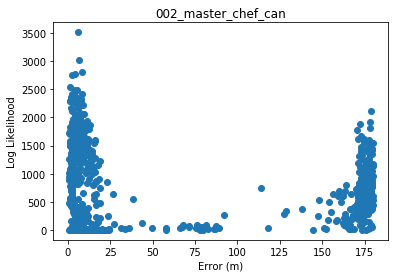

868


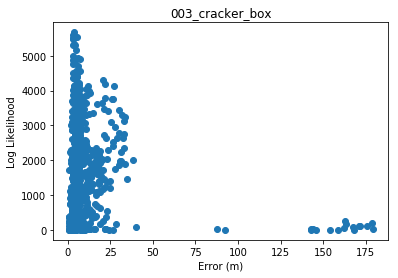

1182


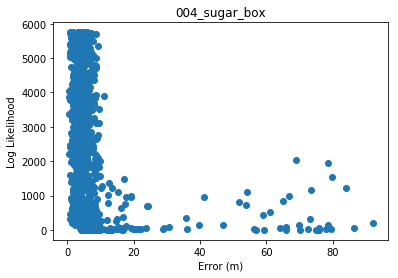

1403


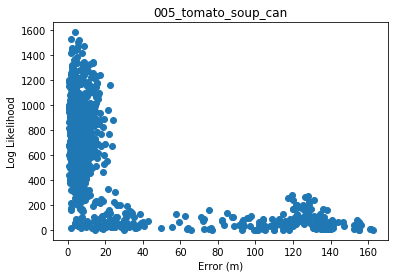

357


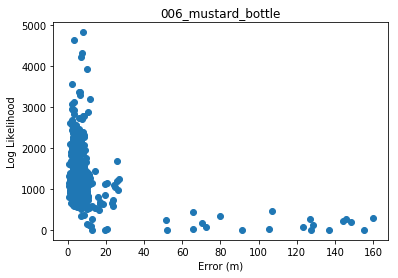

1148


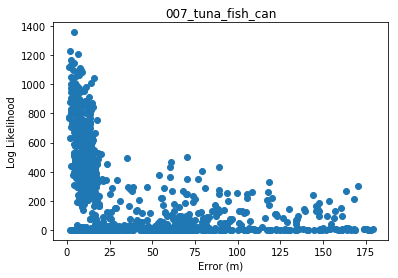

214


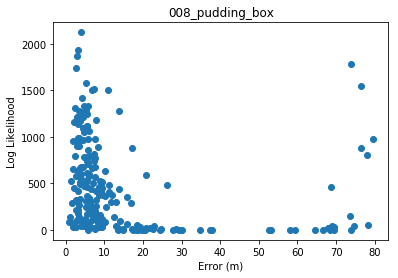

214


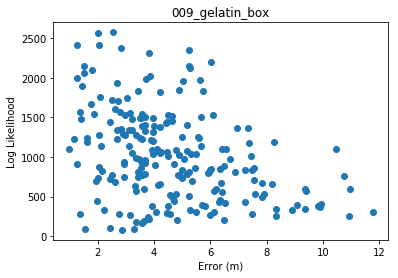

758


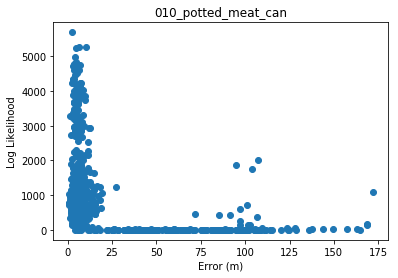

379


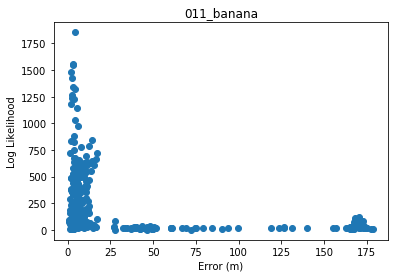

570


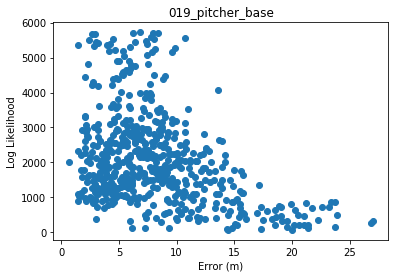

1029


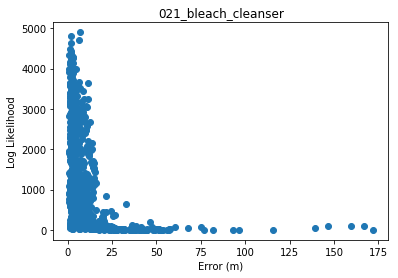

406


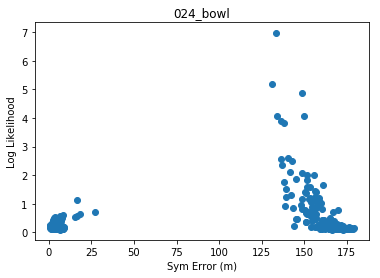

636


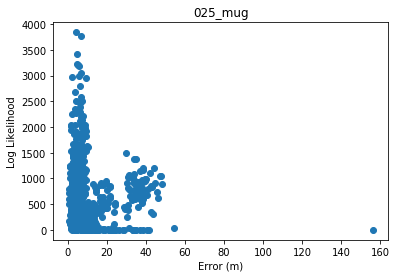

1057


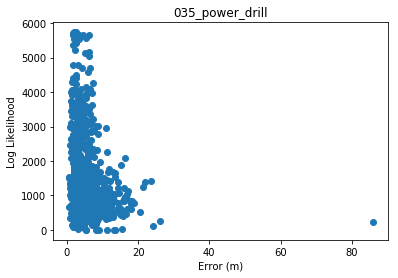

242


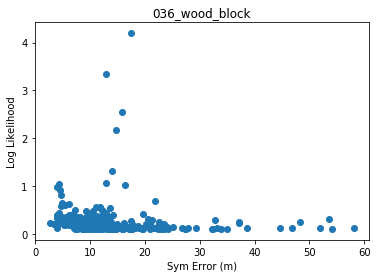

181


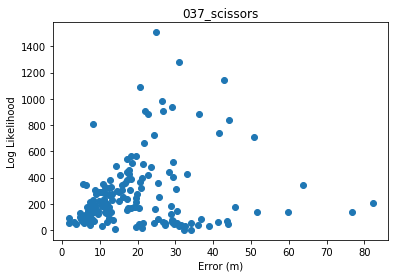

648


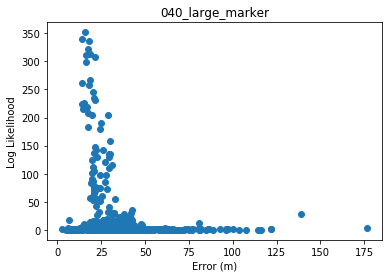

707


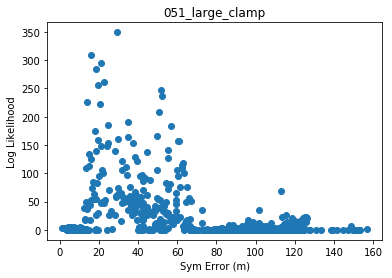

633


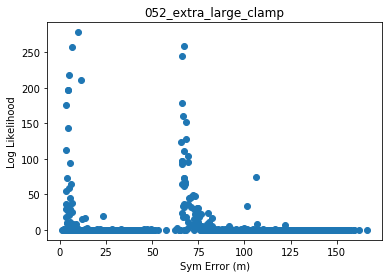

288


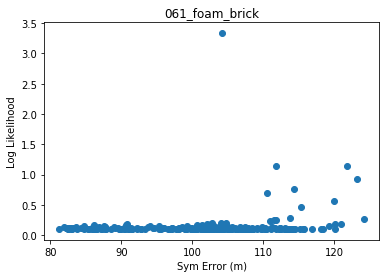

In [525]:
sym_objs
for obj in range(1,22):
    print(len(df_adi[obj]))
    if(obj in sym_objs):
        est_err = list(df_ang[obj].values())
        plt.xlabel('Sym Error (m)')
    else:
        est_err = list(df_ang[obj].values())
        plt.xlabel('Error (m)')

    est_lik = list(df_bing_iso_lik_est[obj].values())
    #print(len(est_err), len(est_lik))
    plt.scatter(est_err, est_lik)
    plt.title(classes[obj])
    plt.ylabel('Log Likelihood')
    plt.show()

1006


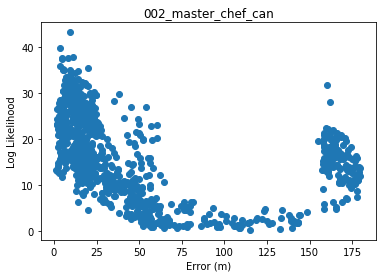

868


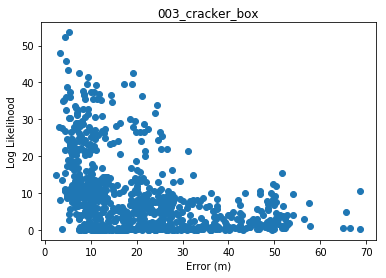

1182


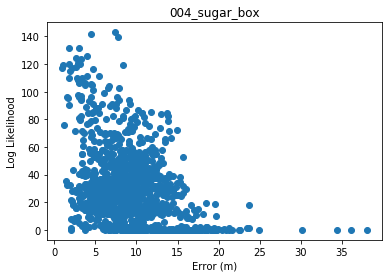

1396


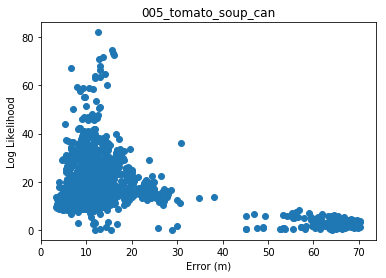

357


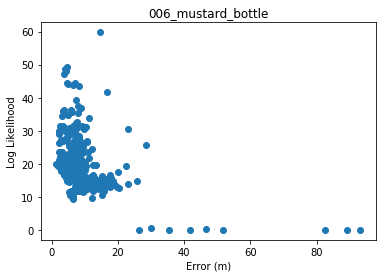

1148


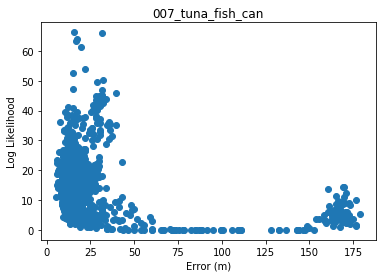

214


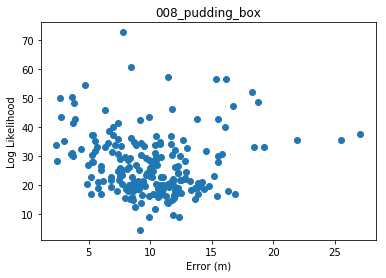

214


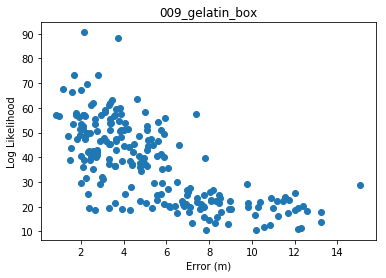

753


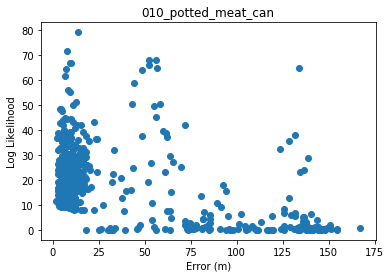

379


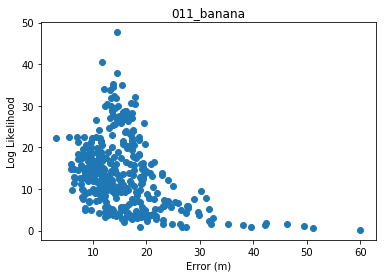

570


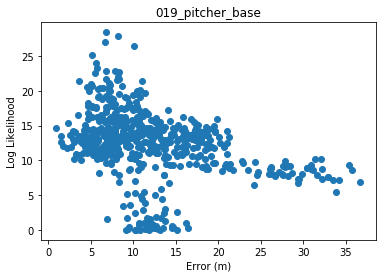

1029


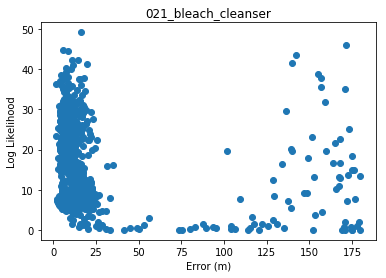

406


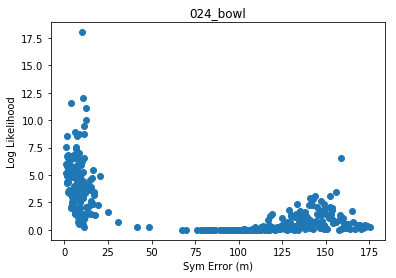

636


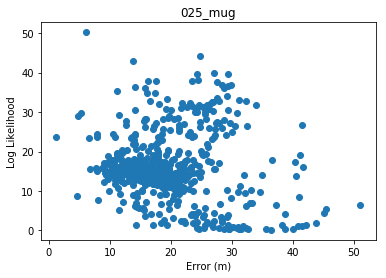

1057


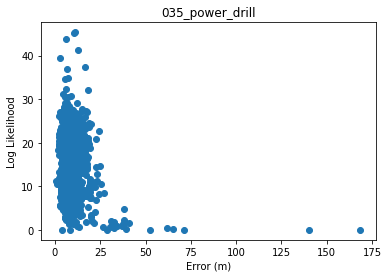

242


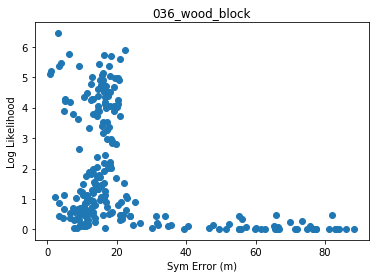

181


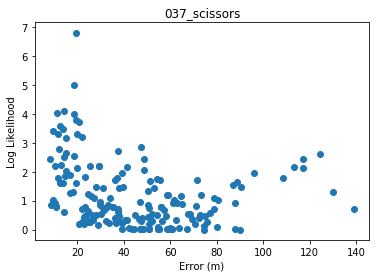

648


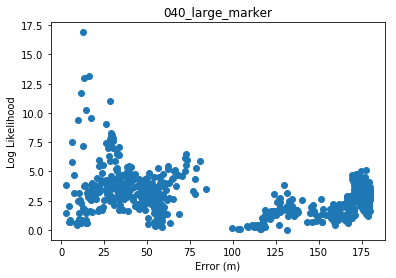

698


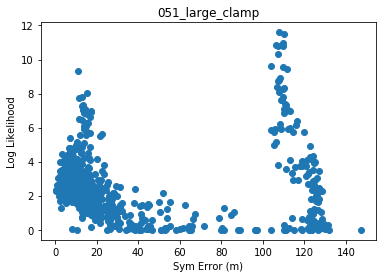

590


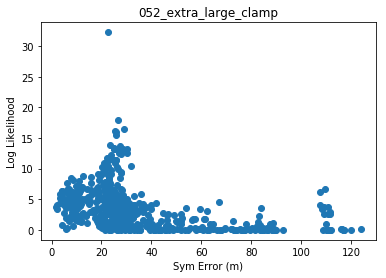

288


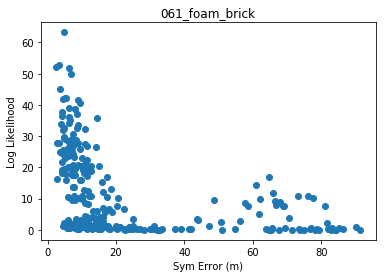

In [524]:
sym_objs
for obj in range(1,22):
    print(len(pc_adi[obj]))
    if(obj in sym_objs):
        est_err = list(pc_ang[obj].values())
        plt.xlabel('Sym Error (m)')
    else:
        est_err = list(pc_ang[obj].values())
        plt.xlabel('Error (m)')

    est_lik = list(pc_hist_comp_lik_est[obj].values())

    plt.scatter(est_err, est_lik)
    plt.title(classes[obj])
    plt.ylabel('Log Likelihood')
    plt.show()

In [72]:
model_filename = dataset_root + '/models/{}/textured.obj'

obj = 12

renderer.deleteAll()
renderer.loadModel(model_filename.format(classes[obj]), emit = 0.5)

(  0.0001 sec |   0.0001 sec) Importing OBJ '/ssd0/datasets/ycb/YCB_Video_Dataset/models/021_bleach_cleanser/textured.obj'...
  (  0.0012 sec |   0.0009 sec) Parsing OBJ file...
    (  7.9977 sec |   7.9965 sec) Done, loading materials and images...
    (  7.9997 sec |   7.9984 sec) Done, building geometries (verts:262146 faces:524288 materials: 1 smoothgroups:1) ...
    ( 19.5252 sec |  19.5239 sec) Done.
  ( 19.5254 sec |  19.5252 sec) Finished importing: '/ssd0/datasets/ycb/YCB_Video_Dataset/models/021_bleach_cleanser/textured.obj'
Progress: 100.00%



UUID('7a41f52d-478c-43d5-81f4-c276f51e0987')

In [78]:
print(dataset.getPath(8670))

0055/000271


8693
0055/000391
add 0.14392266023978142
lik_gt 18.09534072567039
lik_est 0.4058121462243142
q_gt  [-0.55825055  0.6299865  -0.42828172 -0.32870725]
q_est [-0.32778624 -0.7662214   0.4462633  -0.32605228]
t_gt [ 0.13498987 -0.06395144  1.191982  ]
t_est [ 0.1221989  -0.03207572  1.0597173 ]


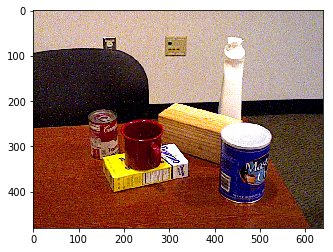

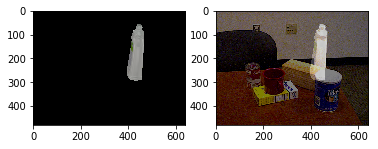

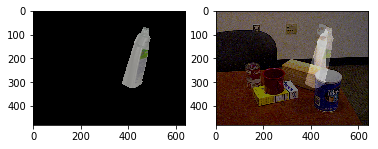

In [83]:
from object_pose_utils.utils.display import *

for idx in pc_add[obj].keys():
    if(pc_add[obj][idx] > 0.1 \
       and pc_hist_comp_lik_gt[obj][idx]>15):
        break
#idx = np.argmin(pc_hist_comp_lik_est[obj])

#v_idx = np.argmax(list(pc_ang[obj].values()))
#idx = list(pc_add[obj].keys())[v_idx]
#idx = 8670
print(idx)
_, q_gt, t_gt, img, depth = dataset[idx]

q_gt = to_np(q_gt)
t_gt = to_np(t_gt)
img = torch2Img(img).astype(np.uint8)
q_est, t_est = pc_est[obj][idx]

print(dataset.getPath(idx))
print('add', pc_add[obj][idx])
print('lik_gt', pc_hist_comp_lik_gt[obj][idx])
print('lik_est', pc_hist_comp_lik_est[obj][idx])
print('q_gt ', q_gt)
print('q_est', q_est)

print('t_gt', t_gt)
print('t_est', t_est)

plt.imshow(img)
plt.show()
img_rend, _ = renderer.renderTrans(getYCBTransform(q_gt, t_gt))
img_rend = cv2.cvtColor(img_rend, cv2.COLOR_BGRA2RGBA)[:,:,:3]
plt.subplot(121)
plt.imshow(img_rend)
plt.subplot(122)
plt.imshow(imageBlend(img, img_rend))
plt.show()

img_rend, _ = renderer.renderTrans(getYCBTransform(q_est, t_est))
img_rend = cv2.cvtColor(img_rend, cv2.COLOR_BGRA2RGBA)[:,:,:3]
plt.subplot(121)
plt.imshow(img_rend)
plt.subplot(122)
plt.imshow(imageBlend(img, img_rend))
plt.show()


In [ ]:
for obj in range(1, 22):
    for j in range(len(dataset)):
        if(j in pc_est[obj].keys()):
            path = dataset.getPath(j)

In [105]:
def robustErrorSum(errs, lik, threshold):
    robust_mask = np.log(lik) > threshold
    robust_err = np.sum(np.array(errs)[robust_mask])
    return robust_err, np.sum(robust_mask)    

In [152]:
est_add_error = pc_add
est_adi_error = pc_adi
est_ang_error = pc_ang
est_likelihoods = pc_hist_comp_lik_est

if(False):
    thresholds = np.concatenate([[-np.inf, -2.29,], np.log([10,50,100,200])-2.29])
    print('###########')
    print('# PoseCNN #')
    print('###########')
    print('Non-Symmetric')
    for th in thresholds:
        sum_add = 0
        sum_ang = 0
        total_used = 0
        total_count = 0
        for obj in non_sym_objs:
            est_lik = list(est_likelihoods[obj].values())
            est_add = list(est_add_error[obj].values())
            est_ang = list(est_ang_error[obj].values())

            err_add, count = robustErrorSum(est_add, est_lik, th)
            err_ang, _ = robustErrorSum(est_ang, est_lik, th)
            sum_add += err_add
            sum_ang += err_ang
            total_used += count
            total_count += len(est_lik)

        print('{:0.0f} & {:0.2f} & {:0.4f} & {:0.0f}'.format(np.exp(th+2.29), 
                                      sum_ang/total_used, 
                                      sum_add/total_used, 
                                      (1-total_used/total_count)*100))

thresholds = np.concatenate([[-np.inf, -2.29,], np.log([2,5,15,30])-2.29])
print('Symmetric')
for th in thresholds:
    sum_adi = 0
    sum_ang = 0
    total_used = 0
    total_count = 0
    
    for obj in sym_objs:
        est_lik = list(est_likelihoods[obj].values())
        est_adi = list(est_adi_error[obj].values())
        est_ang = list(est_ang_error[obj].values())
        
        err_adi, count = robustErrorSum(est_adi, est_lik, th)
        err_ang, _ = robustErrorSum(est_ang, est_lik, th)
        sum_adi += err_adi
        sum_ang += err_ang
        total_used += count
        total_count += len(est_lik)
    
    print('{:0.0f} & {:0.2f} & {:0.4f} & {:0.0f}'.format(np.exp(th+2.29), 
                                  sum_ang/total_used, 
                                  sum_adi/total_used, 
                                  (1-total_used/total_count)*100))

        

if(False):
    est_add_error = df_add
    est_adi_error = df_adi
    est_ang_error = df_ang
    est_likelihoods = df_bing_iso_lik_est

    #thresholds = [-np.inf, -2.29,], + 
    thresholds = np.concatenate([[-np.inf, -2.29,], np.log([50,250,1000,2000])-2.29])
    print('###########')
    print('# DenseFusion #')
    print('###########')
    print('Non-Symmetric')
    for th in thresholds:
        sum_add = 0
        sum_ang = 0
        total_used = 0
        total_count = 0
        for obj in non_sym_objs:
            est_lik = list(est_likelihoods[obj].values())
            est_add = list(est_add_error[obj].values())
            est_ang = list(est_ang_error[obj].values())

            err_add, count = robustErrorSum(est_add, est_lik, th)
            err_ang, _ = robustErrorSum(est_ang, est_lik, th)
            sum_add += err_add
            sum_ang += err_ang
            total_used += count
            total_count += len(est_lik)

        print('{:0.0f} & {:0.2f} & {:0.4f} & {:0.0f}'.format(np.exp(th+2.29), 
                                      sum_ang/total_used, 
                                      sum_add/total_used, 
                                      (1-total_used/total_count)*100))


Symmetric
0 & 40.05 & 0.0478 & 0
1 & 34.13 & 0.0472 & 13
2 & 32.60 & 0.0475 & 16
5 & 29.24 & 0.0468 & 24
15 & 25.43 & 0.0487 & 40
30 & 23.47 & 0.0509 & 62


In [149]:
np.exp(thresholds)/np.exp(-2.29)

array([0.0e+00, 1.0e+00, 5.0e+01, 2.5e+02, 1.0e+03, 2.0e+03])

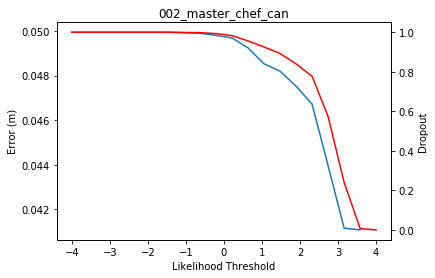

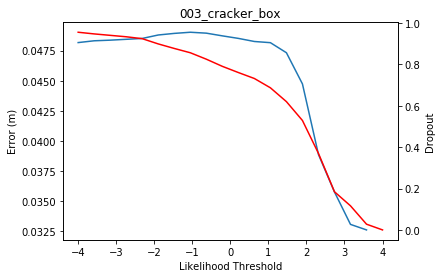

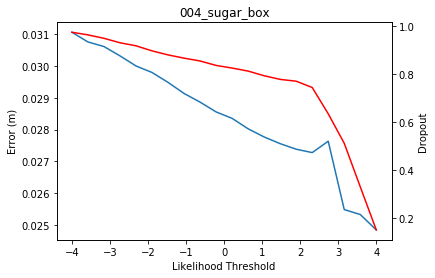

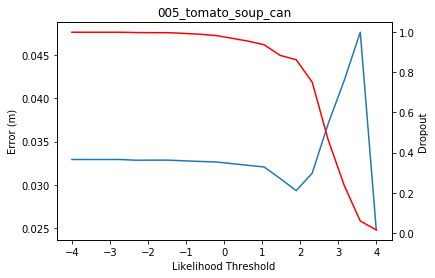

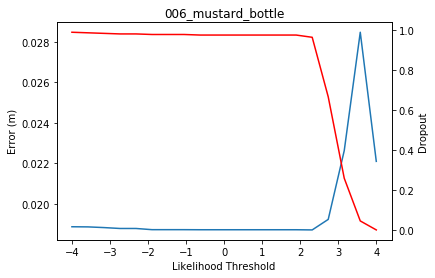

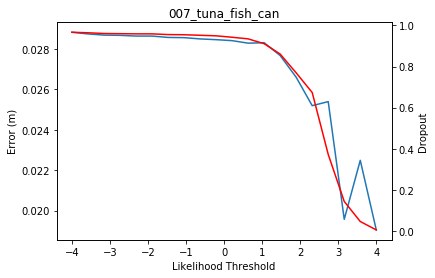

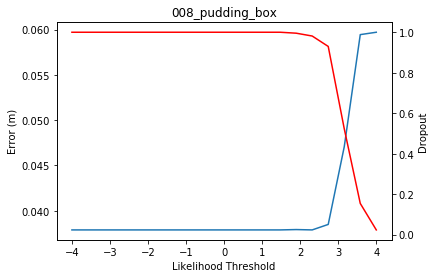

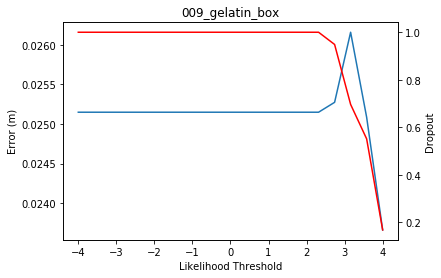

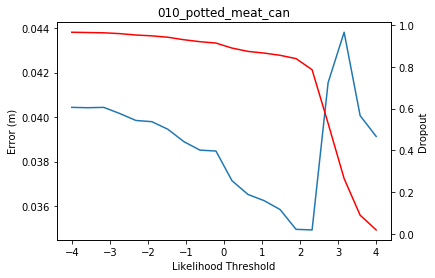

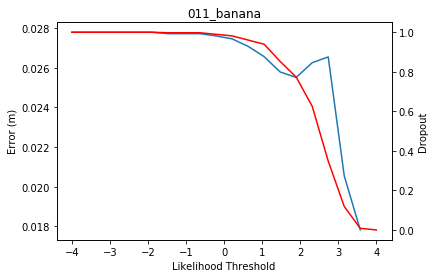

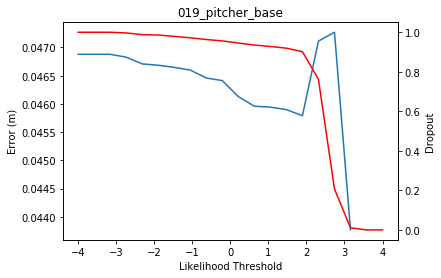

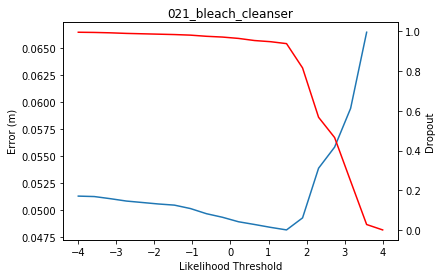

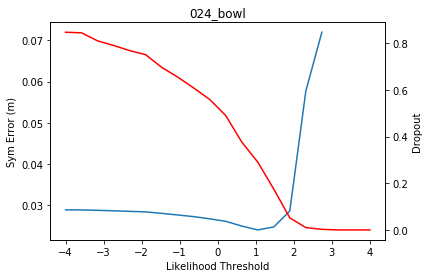

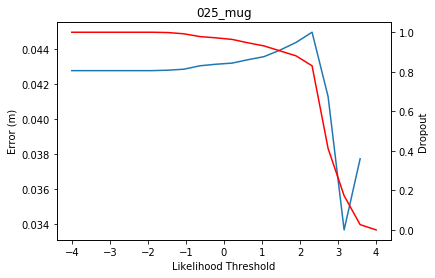

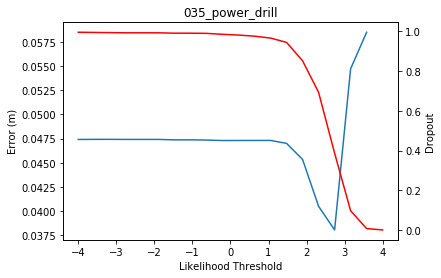

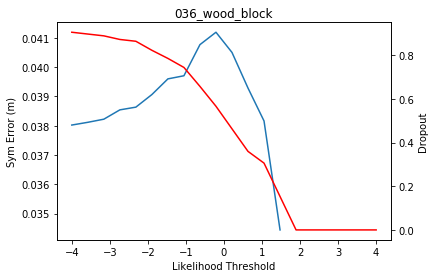

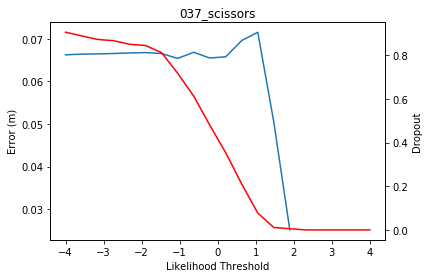

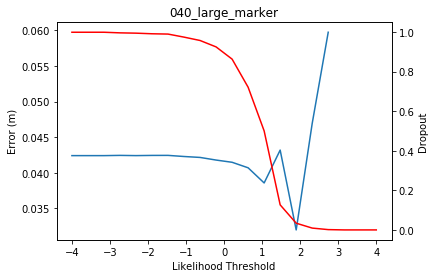

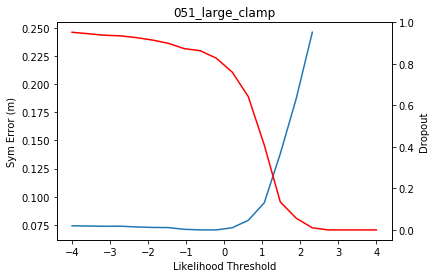

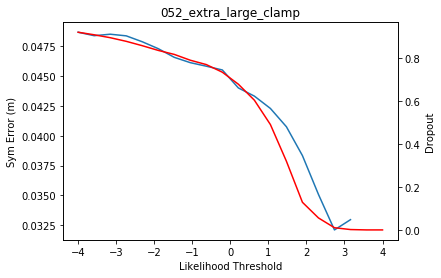

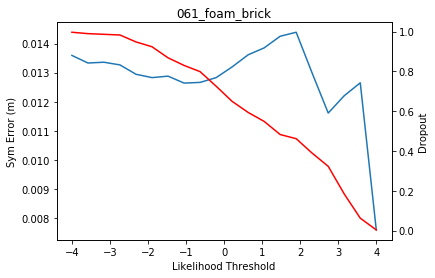

In [97]:
#est_add = df_add
#est_adi = df_adi
#est_likelihoods = df_bing_iso_lik_est
    
est_add = pc_add
est_adi = pc_adi
est_likelihoods = pc_hist_comp_lik_est
    
for obj in range(1,22):
    #if(obj not in sym_objs):
    #    continue

    fig, ax1 = plt.subplots()
    #ax1.set_xscale('log')
    ax2 = ax1.twinx()
    plt.title(classes[obj])
    ax1.set_xlabel('Likelihood Threshold')
    ax2.set_ylabel('Dropout')

    if(obj in sym_objs):
        est_err = list(est_adi[obj].values())
        ax1.set_ylabel('Sym Error (m)')
    else:
        est_err = list(est_add[obj].values())
        ax1.set_ylabel('Error (m)')
    
    est_lik = list(est_likelihoods[obj].values())
    
    mu = np.mean(est_lik)
    sig = np.std(est_lik)
    errs = []
    drops = []
    #thrsholds = np.linspace(np.min(np.log(est_lik)), np.max(np.log(est_lik)))
    thrsholds = np.linspace(-4,4,20)
    #[0, np.exp(-2.19), mu-sig, mu, mu+sig, mu+1.5*sig]
    
    for th in thrsholds:
        robust_adi, drop_adi = robustError(est_err, est_lik, th)
        errs.append(robust_adi)
        drops.append(drop_adi)
        #print('{:0.2f}: {:0.5f} {:0.1f}'.format(th, robust_adi, 100*drop_adi))
    
    ax1.plot(thrsholds, errs)    
    ax2.plot(thrsholds, drops, 'r')
    plt.show()
#pc_add = pc_data['add_err']


In [ ]:
#est_add = df_add
#est_adi = df_adi
#est_likelihoods = df_bing_iso_lik_est
    
est_add = pc_add
est_adi = pc_adi
est_likelihoods = pc_hist_comp_lik_est
    
for obj in range(1,22):
    #if(obj not in sym_objs):
    #    continue

    fig, ax1 = plt.subplots()
    #ax1.set_xscale('log')
    ax2 = ax1.twinx()
    plt.title(classes[obj])
    ax1.set_xlabel('Likelihood Threshold')
    ax2.set_ylabel('Dropout')

    if(obj in sym_objs):
        est_err = list(est_adi[obj].values())
        ax1.set_ylabel('Sym Error (m)')
    else:
        est_err = list(est_add[obj].values())
        ax1.set_ylabel('Error (m)')
    
    est_lik = list(est_likelihoods[obj].values())
    
    mu = np.mean(est_lik)
    sig = np.std(est_lik)
    errs = []
    drops = []
    #thrsholds = np.linspace(np.min(np.log(est_lik)), np.max(np.log(est_lik)))
    thrsholds = np.linspace(-4,4,20)
    #[0, np.exp(-2.19), mu-sig, mu, mu+sig, mu+1.5*sig]
    
    for th in thrsholds:
        robust_adi, drop_adi = robustError(est_err, est_lik, th)
        errs.append(robust_adi)
        drops.append(drop_adi)
        #print('{:0.2f}: {:0.5f} {:0.1f}'.format(th, robust_adi, 100*drop_adi))
    
    ax1.plot(thrsholds, errs)    
    ax2.plot(thrsholds, drops, 'r')
    plt.show()
#pc_add = pc_data['add_err']


In [245]:
for obj in range(1,22):
    print(classes[obj])
    est_add = list(pc_add[obj].values())
    est_adi = list(pc_adi[obj].values())
    est_lik = list(pc_hist_comp_lik_est[obj].values())
    mu = np.mean(est_lik)
    sig = np.std(est_lik)
    errs = []
    drops = []
    for th in [0, np.exp(-2.19), mu-sig, mu, mu+sig, mu+1.5*sig]:
        robust_adi, drop_adi = robustError(est_add, est_lik, np.log(th))
        print('{:0.2f}: {:0.5f} {:0.1f}'.format(th, robust_adi, 100*drop_adi))
#pc_add = pc_data['add_err']


002_master_chef_can
0.00: 0.04994 100.0
0.11: 0.04994 100.0
8.20: 0.04726 81.8
16.82: 0.04302 47.7
25.45: 0.04229 18.4
29.76: 0.04425 6.7
003_cracker_box
0.00: 0.04743 100.0
0.11: 0.04862 91.6
-0.31: nan 0.0
9.58: 0.04017 40.2
19.46: 0.03373 15.8
24.40: 0.03268 10.4
004_sugar_box
0.00: 0.03170 100.0
0.11: 0.02997 91.5
2.24: 0.02794 80.1
29.65: 0.02484 42.8
57.06: 0.02430 13.4
70.77: 0.02214 8.7
005_tomato_soup_can
0.00: 0.03299 100.0
0.11: 0.03285 99.8
5.88: 0.02967 86.9
17.26: 0.03793 38.0
28.64: 0.04475 14.1
34.33: 0.04937 6.9
006_mustard_bottle
0.00: 0.01910 100.0
0.11: 0.01878 98.0
11.72: 0.01869 94.7
20.07: 0.02030 43.1
28.41: 0.02474 13.7
32.58: 0.02961 6.2
007_tuna_fish_can
0.00: 0.02940 100.0
0.11: 0.02864 95.9
4.46: 0.02767 85.7
14.56: 0.02581 43.7
24.67: 0.01939 12.5
29.73: 0.02015 8.4
008_pudding_box
0.00: 0.03789 100.0
0.11: 0.03789 100.0
16.38: 0.03851 91.1
26.83: 0.05341 41.6
37.27: 0.06014 12.6
42.49: 0.05945 8.9
009_gelatin_box
0.00: 0.02515 100.0
0.11: 0.02515 100.0
21

In [200]:

for obj in range(1,22):
    print(classes[obj])
    print('Est: {:0.2f}'.format(mean_log_clean(list(pc_hist_comp_lik_est[obj].values()))))
    print('GT : {:0.2f}'.format(mean_log_clean(list(pc_hist_comp_lik_gt[obj].values()))))

002_master_chef_can
Est: 2.60
GT : 2.32
003_cracker_box
Est: 1.17
GT : -0.09
004_sugar_box
Est: 2.28
GT : 2.62
005_tomato_soup_can
Est: 2.57
GT : 2.52
006_mustard_bottle
Est: 2.79
GT : 3.02
007_tuna_fish_can
Est: 2.05
GT : 2.64
008_pudding_box
Est: 3.22
GT : 3.13
009_gelatin_box
Est: 3.52
GT : 3.53
010_potted_meat_can
Est: 2.23
GT : 1.60
011_banana
Est: 2.36
GT : 2.27
019_pitcher_base
Est: 2.30
GT : 2.35
021_bleach_cleanser
Est: 2.43
GT : 2.29
024_bowl
Est: -1.15
GT : -1.21
025_mug
Est: 2.53
GT : 2.75
035_power_drill
Est: 2.45
GT : 2.43
036_wood_block
Est: -0.61
GT : -0.51
037_scissors
Est: -0.70
GT : 0.66
040_large_marker
Est: 0.88
GT : 1.02
051_large_clamp
Est: 0.18
GT : -1.63
052_extra_large_clamp
Est: 0.08
GT : 0.19
061_foam_brick
Est: 1.14
GT : 1.70


In [241]:
#fn = 'ral_results/final_single_img_hist_reg_local_hist_reg_global_hist_comp_local_hist_comp_global_bing_iso_bing_duel_results.npz'
#fn = 'ral_results/final_single_img_bing_fixed_results.npz'
#fn = 'ral_results/final_pcnn_single_img_bing_iso_bing_duel_results.npz'
#fn = 'ral_results/final_pcnn_single_img_bing_fixed_results.npz'
#fn = 'ral_results/pcnn_single_img_bing_dropout_results.npz'
#fn = 'ral_results/single_img_dropout_50_orig_results.npz'
#fn = 'ral_results/pcnn_single_img_fused_hist_reg_fc6_hist_cosine_hist_uniform_bing_fixed_results.npz'
#fn = 'ral_results/single_img_results.npz'
#fn = 'ral_results/pcnn_single_img_hist_conf_bing_iso_bing_duel_results.npz'
fn = 'ral_results/single_img_hist_cosine_results.npz'
#fn = 'ral_results/pcnn_single_img_hist_cosine_results.npz'

data = np.load(fn, allow_pickle=True)

for alg_k in data['likelihood'].item().keys():
    results = {}
    if(alg_k != 'hist_cosine'):
        continue
    for res_k in data.keys():
        if(res_k == 'lik_distribution'):
            continue
        results[res_k] = {alg_k:data[res_k].item()[alg_k]}
    print(alg_k)
    np.savez('ral_results/indiv_new/df_{}.npz'.format(alg_k),
             **results)

hist_cosine


In [119]:
#data = np.load(fn, allow_pickle=True)
fn = 'ral_results/final_single_img_hist_reg_local_hist_reg_global_hist_comp_local_hist_comp_global_bing_iso_bing_duel_results.npz'
test_results = {}
updateResults(test_results, fn)
to_list(test_results)
print(list(test_results['likelihood'].keys()))
print(makeTableEntries(test_results['likelihood'], objs = non_sym_objs, 
                 val_func=mean_log_clean, bold_func = max))

['hist_reg_local', 'hist_reg_global', 'hist_comp_local', 'hist_comp_global', 'bing_iso', 'bing_duel']
All 
 & 0.45 & 0.28 & 0.73 & 1.18 & \textbf{2.80} & 2.56 \\



In [59]:
def to_list(results):
    for res_k, res_v in results.items():
        for alg_k, alg_v in res_v.items():
            for k, v in alg_v.items():
                if(res_k not in results.keys()):
                    test_results[res_k] = {}
                if(alg_k not in results[res_k].keys()):
                    test_results[res_k][alg_k] = {}
                if(k not in results[res_k][alg_k].keys()):
                    test_results[res_k][alg_k][k] = {}
                if(type(v) is dict):
                    results[res_k][alg_k][k] = list(v.values())


In [64]:
#for fn in glob.glob('ral_results/*cos*'):
#    if('pcnn' not in fn):
#        print(fn)
test_results1 = {}
updateResults(test_results1, 'ral_results/single_img_hist_cosine_results.npz')
test_results2 = {}
updateResults(test_results2, 'ral_results/single_imghist_cosign_results.npz')
test_results3 = {}
updateResults(test_results3, 'ral_results/single_img_cosin_orig_results.npz')

print(test_results1['likelihood'].keys())
print(test_results2['likelihood'].keys())
print(test_results3['likelihood'].keys())

to_list(test_results1)
to_list(test_results2)
to_list(test_results3)

print('='*50)

print(makeTableEntries(df_results['likelihood'], keys=['hist_cosine'], objs = non_sym_objs, 
                 val_func=mean_log_clean, bold_func = max,
                 agg_title = 'Non-Symmetric-DF'))
print(makeTableEntries(pc_results['likelihood'], keys=['hist_cosine'], objs = non_sym_objs, 
                 val_func=mean_log_clean, bold_func = max,
                 agg_title = 'Non-Symmetric-DF'))
print('-'*50)
print(makeTableEntries(test_results1['likelihood'], keys=['hist_cosine'], objs = non_sym_objs, 
                 val_func=mean_log_clean, bold_func = max,
                 agg_title = 'Non-Symmetric-DF'))
print(makeTableEntries(test_results2['likelihood'], keys=['hist_cosign'], objs = non_sym_objs, 
                 val_func=mean_log_clean, bold_func = max,
                 agg_title = 'Non-Symmetric-DF'))
print(makeTableEntries(test_results3['likelihood'], keys=['hist_cosign'], objs = non_sym_objs, 
                 val_func=mean_log_clean, bold_func = max,
                 agg_title = 'Non-Symmetric-DF'))


dict_keys(['hist_cosine'])
dict_keys(['hist_cosign'])
dict_keys(['hist_cosign'])
Non-Symmetric-DF 
 & nan \\

Non-Symmetric-DF 
 & \textbf{-1.90} \\

--------------------------------------------------
Non-Symmetric-DF 
 & \textbf{-1.90} \\

Non-Symmetric-DF 
 & \textbf{-2.16} \\

Non-Symmetric-DF 
 & \textbf{-2.16} \\



In [6]:
print(df_results['likelihood']['bing_fixed'][1][0])
print(np.mean(np.log(df_results['likelihood']['bing_fixed'][1][0])))
print(np.load('df_new_sigmas.npz', allow_pickle=True)['single_sigma'].item()[1])
len(df_results['likelihood']['bing_fixed'][1])

45.337440490722656
3.814133192024154
53.06759009009921


1006

In [7]:
hist_global_results = 'ral_results/single_img_hist_orig_results.npz'
hist_conf_results = 'ral_results/single_img_hist_conf_orig_results.npz'
bing_fixed_results = 'ral_results/single_img_bing_results.npz'
hist_cos_results = 'ral_results/single_img_hist_cosine_results.npz'
hist_uniform_results = 'ral_results/single_img_uniform_results.npz'
hist_bing_results = 'ral_results/single_img_bing_iso_bing_duel_results.npz'
hist_dropout_results = 'ral_results/single_img_dropout_50_orig_results.npz'

results_1 = 'ral_results/pcnn_single_img_hist_cosine_results.npz'
results_2 = 'ral_results/pcnn_single_img_fused_hist_reg_fc6_hist_cosine_hist_uniform_bing_fixed_results.npz'
results_3 = 'ral_results/pcnn_single_img_hist_comp_fc6_results.npz'
results_4 = 'ral_results/pcnn_single_img_hist_conf_bing_iso_bing_duel_results.npz'
results_5 = 'ral_results/pcnn_single_img_bing_dropout_results.npz'

results_bing_reg = 'ral_results/final_pcnn_single_img_bing_iso_bing_duel_results.npz'

In [297]:
table_heading_old = """ &  & \multicolumn{4}{c|}{Histogram} & \multicolumn{5}{c||}{Bingham} \\\\\n\\hline
Objects & Uniform & Conf & Reg & Comp & Cosine & Fixed & Mix & Dropout & Reg Iso & Reg Full \\\\"""

""" 
 &  & \\multicolumn{4}{c||}{Histogram} & \\multicolumn{5}{c||}{Bingham} \\\
\\hline
 &  & Stat & \\multicolumn{3}{c||}{Learned} & \\multicolumn{3}{c||} Stat & \\multicolumn{2}{c||} Learned \\\
\\hline
Objects & Uniform & Conf & Reg & Comp & Cosine & Fixed & Mix & Dropout & Reg Iso & Reg Full \\\
""";

table_heading = """ &  & \multicolumn{2}{c||}{Our Method} & \multicolumn{5}{c||}{Baselines} \\\\\n\\hline
Objects & Bingham Regression & Learned Comparison & Uniform & Fixed Bingham & Dropout & Confusion Matrix & Cosine Distance & Histogram Regression \\\\"""



In [302]:
#df_v['hist_cosine']
from object_pose_utils.bbTrans.discretized4dSphere import S3Grid

#grid = S3Grid(2)
#grid.Simplify()
num_verts = len(grid.vertices)
print(num_verts)

3885


In [300]:
k = 'likelihood'
df_v = df_results[k]
pc_v = pc_results[k]

table_str = ''
table_str += makeTableHeading([h.replace('_', ' ') for h in df_v.keys()],
                             heading = table_heading)

table_str += makeTableEntries(df_v, keys=df_algorithm_keys, objs = non_sym_objs, 
                              val_func=mean_log_clean, bold_func = max,
                              agg_title = 'Non-Symmetric-DF')
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys, objs = non_sym_objs, 
                              val_func=mean_log_clean, bold_func = max,
                              agg_title = 'Non-Symmetric-PC')
table_str += "\\hline\n"
table_str += "\\hline\n"
table_str += makeTableEntries(df_v, keys=df_algorithm_keys, objs = sym_objs,
                              val_func=mean_log_clean, bold_func = max, 
                              agg_title = 'Symmetric-DF')
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys, objs = sym_objs,
                              val_func=mean_log_clean, bold_func = max, 
                              agg_title = 'Symmetric-PC')
table_str += "\\hline\n"
table_str += "\\hline\n"
table_str += makeTableEntries(df_v, keys=df_algorithm_keys, val_func=mean_log_clean, bold_func = max, 
                             agg_title = 'All-DF')
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys, val_func=mean_log_clean, bold_func = max, 
                             agg_title = 'All-PC')
#table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
table_str += makeTableEnding(caption = 'Mean Log Likelihood of Ground Truth Orientation')
print(table_str)

\begin{table*}[h!]
\small
\centering
\begin{tabular} {||c||c|c|c|c|c|c|c|c|c|c|c||}
\hline
  &  & \multicolumn{2}{c||}{Our Method} & \multicolumn{5}{c||}{Baselines} \\
\hline
Objects & Bingham Regession & Learned Comparison & Uniform & Fixed Bingham & Dropout & Confusion Matrix & Cosine Distance & Histogram Regression \\
\hline
Non-Symmetric-DF 
 & \textbf{2.80} & 1.18 & -2.29 & 1.74 & 0.70 & 1.63 & -1.90 & 0.28 \\
Non-Symmetric-PC 
 & 1.91 & 2.17 & -2.29 & 1.50 & \textbf{2.71} & -2.46 & -0.92 & 1.87 \\
\hline
\hline
Symmetric-DF 
 & -3.81 & -5.54 & -2.29 & -3.66 & -8.09 & -2.91 & \textbf{-2.23} & -2.57 \\
Symmetric-PC 
 & -8.82 & \textbf{-0.52} & -2.29 & -9.18 & -5.28 & -7.75 & -1.55 & -1.23 \\
\hline
\hline
All-DF 
 & \textbf{1.72} & 0.08 & -2.29 & 0.86 & -0.74 & 0.88 & -1.95 & -0.19 \\
All-PC 
 & 0.19 & \textbf{1.74} & -2.29 & -0.22 & 1.43 & -3.31 & -1.02 & 1.37 \\
\hline
\end{tabular}
\caption{Mean Log Likelihood of Ground Truth Orientation}
\end{table*}



In [21]:
k = 'add_error_mode'
df_v = df_results[k]
pc_v = pc_results[k]

table_str = ''
table_str += makeTableHeading([h.replace('_', ' ') for h in df_v.keys()],
                              heading = table_heading)
table_str += makeTableEntries(df_v, keys=df_algorithm_keys,
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max, 
                             individual = True)
#table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
table_str += makeTableEnding(caption = 'AUC of Average Distance Error of Distribution Mode')
print(table_str)
print("\n\n\n\n")

table_str = ''
table_str += makeTableHeading([h.replace('_', ' ') for h in pc_v.keys()],
                              heading = table_heading)
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys,
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max, 
                             individual = True)
#table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
table_str += makeTableEnding(caption = 'AUC of Average Distance Error of Distribution Mode')
print(table_str)
print("\n\n\n\n")


\begin{table*}[h!]
\small
\centering
\begin{tabular} {||c||c|c|c|c|c|c|c|c|c|c||}
\hline
  &  & \multicolumn{4}{c|}{Histogram} & \multicolumn{5}{c||}{Bingham} \\
\hline
Objects & Uniform & Conf & Reg & Comp & Cosine & Fixed & Mix & Dropout & Reg Iso & Reg Full \\
\hline
master chef can
 & 0.00 & 65.45 & 56.85 & 56.36 & 49.81 & \textbf{68.89} & \textbf{68.89} & 12.75 & 68.87 & 68.87 \\
cracker box
 & 0.00 & 80.56 & 52.27 & 64.08 & 61.75 & 83.78 & 83.78 & 4.40 & \textbf{83.90} & \textbf{83.90} \\
sugar box
 & 5.85 & 87.75 & 80.27 & 80.42 & 76.32 & 91.01 & 91.01 & 10.24 & \textbf{91.04} & \textbf{91.04} \\
tomato soup can
 & 27.78 & 82.05 & 79.41 & 82.80 & 80.37 & 84.48 & 84.48 & 15.47 & \textbf{84.49} & \textbf{84.49} \\
mustard bottle
 & 0.81 & 88.23 & 80.18 & 80.47 & 79.42 & \textbf{91.92} & \textbf{91.92} & 13.79 & 91.76 & 91.76 \\
tuna fish can
 & 50.86 & 77.78 & 72.51 & 74.24 & 70.42 & \textbf{79.94} & \textbf{79.94} & 19.50 & 79.93 & 79.93 \\
pudding box
 & 18.17 & 81.42 & 65.09 & 

In [22]:
k = 'add_sym_error_mode'
df_v = df_results[k]
pc_v = pc_results[k]

table_str = ''
table_str += makeTableHeading([h.replace('_', ' ') for h in df_v.keys()],
                              heading = table_heading)
table_str += makeTableEntries(df_v, keys=df_algorithm_keys,
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max, 
                             individual = True)
#table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
table_str += makeTableEnding(caption = 'AUC of Average Symetric Distance Error of Distribution Mode using DenseFusion Features')
print(table_str)
print("\n\n\n\n")

table_str = ''
table_str += makeTableHeading([h.replace('_', ' ') for h in pc_v.keys()],
                              heading = table_heading)
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys,
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max, 
                             individual = True)
#table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
table_str += makeTableEnding(caption = 'AUC of Average Distance Error of Distribution Mode using PoseCNN Features')
print(table_str)
print("\n\n\n\n")


\begin{table*}[h!]
\small
\centering
\begin{tabular} {||c||c|c|c|c|c|c|c|c|c|c||}
\hline
  &  & \multicolumn{4}{c|}{Histogram} & \multicolumn{5}{c||}{Bingham} \\
\hline
Objects & Uniform & Conf & Reg & Comp & Cosine & Fixed & Mix & Dropout & Reg Iso & Reg Full \\
\hline
master chef can
 & 85.00 & 93.89 & 92.88 & 93.27 & 93.09 & 94.39 & 94.39 & 40.20 & \textbf{94.41} & \textbf{94.41} \\
cracker box
 & 70.90 & 90.66 & 85.45 & 86.78 & 86.97 & 91.73 & 91.73 & 22.71 & \textbf{91.78} & \textbf{91.78} \\
sugar box
 & 77.29 & 94.08 & 91.50 & 91.35 & 89.80 & 95.34 & 95.34 & 31.61 & \textbf{95.39} & \textbf{95.39} \\
tomato soup can
 & 88.35 & 95.15 & 93.92 & 94.95 & 94.77 & \textbf{95.70} & \textbf{95.70} & 33.12 & 95.69 & 95.69 \\
mustard bottle
 & 79.79 & 95.12 & 92.27 & 92.38 & 92.20 & \textbf{96.30} & \textbf{96.30} & 41.88 & 96.26 & 96.26 \\
tuna fish can
 & 90.83 & 95.60 & 94.54 & 95.34 & 93.73 & \textbf{96.00} & \textbf{96.00} & 44.76 & 95.99 & 95.99 \\
pudding box
 & 87.00 & 92.54 & 88.

In [27]:
k = 'sym_angular_error'
df_v = df_results[k]
pc_v = pc_results[k]

table_str = ''
table_str += makeTableHeading([h.replace('_', ' ') for h in df_v.keys()],
                              heading = table_heading)
table_str += makeTableEntries(df_v, keys=df_algorithm_keys,
                              val_func=partial(accuracyAUC100, max_theshold=180), bold_func = max, 
                             individual = True)
#table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
table_str += makeTableEnding(caption = 'AUC of Symetric Angular Error of Distribution Mode using DenseFusion')
print(table_str)
print("\n\n\n\n")

table_str = ''
table_str += makeTableHeading([h.replace('_', ' ') for h in pc_v.keys()],
                              heading = table_heading)
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys,
                              val_func=partial(accuracyAUC100, max_theshold=180), bold_func = max, 
                             individual = True)
#table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
table_str += makeTableEnding(caption = 'AUC of Symetric Angular Error of Distribution Mode using PoseCNN')
print(table_str)
print("\n\n\n\n")


\begin{table*}[h!]
\small
\centering
\begin{tabular} {||c||c|c|c|c|c|c|c|c|c|c||}
\hline
  &  & \multicolumn{4}{c|}{Histogram} & \multicolumn{5}{c||}{Bingham} \\
\hline
Objects & Uniform & Conf & Reg & Comp & Cosine & Fixed & Mix & Dropout & Reg Iso & Reg Full \\
\hline
master chef can
 & 70.49 & 70.49 & 70.49 & 70.49 & 70.49 & \textbf{70.53} & \textbf{70.53} & 56.10 & 70.49 & 70.49 \\
cracker box
 & \textbf{94.29} & \textbf{94.29} & \textbf{94.29} & \textbf{94.29} & \textbf{94.29} & 94.19 & 94.19 & 68.33 & \textbf{94.29} & \textbf{94.29} \\
sugar box
 & \textbf{96.39} & \textbf{96.39} & \textbf{96.39} & \textbf{96.39} & \textbf{96.39} & 96.38 & 96.38 & 77.08 & \textbf{96.39} & \textbf{96.39} \\
tomato soup can
 & \textbf{83.92} & \textbf{83.92} & \textbf{83.92} & \textbf{83.92} & \textbf{83.92} & 83.86 & 83.86 & 69.35 & \textbf{83.92} & \textbf{83.92} \\
mustard bottle
 & 93.61 & 93.61 & 93.61 & 93.61 & 93.61 & \textbf{93.77} & \textbf{93.77} & 65.95 & 93.61 & 93.61 \\
tuna fish can
 

In [37]:
#k = 'sym_angular_error'
k = 'likelihood'
df_v = df_results[k]
pc_v = pc_results[k]

print(pc_v['hist_uniform'][1][1])
print(pc_v['hist_reg_fc6'][1][1])

0.10132116079330444
60.02710172876286


In [25]:
k = 'likelihood'
df_v = df_results[k]
pc_v = pc_results[k]

table_str = ''
table_str += makeTableHeading([h.replace('_', ' ') for h in df_v.keys()],
                              heading = table_heading)
table_str += makeTableEntries(df_v, keys=df_algorithm_keys,
                              val_func=mean_log_clean, bold_func = max, 
                             individual = True)
#table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
table_str += makeTableEnding(caption = 'Mean Log Likelihood of Ground Truth Orientation using DenseFusion')
print(table_str)
print("\n\n\n\n")

table_str = ''
table_str += makeTableHeading([h.replace('_', ' ') for h in pc_v.keys()],
                              heading = table_heading)
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys,
                              val_func=mean_log_clean, bold_func = max, 
                             individual = True)
#table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
table_str += makeTableEnding(caption = 'Mean Log Likelihood of Ground Truth Orientation using PoseCNN')
print(table_str)
print("\n\n\n\n")


\begin{table*}[h!]
\small
\centering
\begin{tabular} {||c||c|c|c|c|c|c|c|c|c|c||}
\hline
  &  & \multicolumn{4}{c|}{Histogram} & \multicolumn{5}{c||}{Bingham} \\
\hline
Objects & Uniform & Conf & Reg & Comp & Cosine & Fixed & Mix & Dropout & Reg Iso & Reg Full \\
\hline
master chef can
 & -2.29 & -0.78 & -2.82 & 1.01 & -1.91 & -0.97 & -0.94 & -1.04 & -1.66 & \textbf{1.21} \\
cracker box
 & -2.29 & \textbf{4.03} & -1.00 & 2.26 & -1.91 & 1.13 & 1.68 & 1.14 & 3.75 & 1.81 \\
sugar box
 & -2.29 & 3.77 & 2.64 & 2.24 & -1.80 & 0.04 & 0.97 & 1.95 & \textbf{5.94} & -0.06 \\
tomato soup can
 & -2.29 & 0.90 & -2.24 & 1.61 & -1.73 & -0.27 & -0.02 & 1.16 & \textbf{2.02} & 1.63 \\
mustard bottle
 & -2.29 & 3.85 & -1.21 & 2.15 & -1.73 & 2.38 & 2.41 & 1.12 & \textbf{4.61} & 1.73 \\
tuna fish can
 & -2.29 & -3.12 & -5.86 & \textbf{0.42} & -2.05 & -1.17 & -2.19 & -0.96 & -0.20 & 0.31 \\
pudding box
 & -2.29 & 2.18 & -0.18 & -1.35 & -1.95 & 1.15 & 1.19 & 0.82 & \textbf{2.64} & 0.47 \\
gelatin box
 & -2.2

In [23]:
k = 'likelihood'
df_v = df_results[k]
pc_v = pc_results[k]

table_str = ''
table_str += makeTableHeading([h.replace('_', ' ') for h in df_v.keys()],
                              heading = table_heading)
table_str += makeTableEntries(df_v, keys=df_algorithm_keys,
                              val_func=mean_log_clean, bold_func = max, 
                             individual = True)
#table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
table_str += makeTableEnding(caption = 'AUC of Average Distance Error of Distribution Mode')
print(table_str)
print("\n\n\n\n")

table_str = ''
table_str += makeTableHeading([h.replace('_', ' ') for h in pc_v.keys()],
                              heading = table_heading)
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys,
                              val_func=mean_log_clean, bold_func = max, 
                             individual = True)
#table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
table_str += makeTableEnding(caption = 'AUC of Average Distance Error of Distribution Mode')
print(table_str)
print("\n\n\n\n")


k = 'add_sym_error_mode'
df_v = df_results[k]
pc_v = pc_results[k]

table_str = ''
table_str += makeTableHeading([h.replace('_', ' ') for h in v_df.keys()],
                              heading = table_heading)

table_str += makeTableEntries(df_v, keys=df_algorithm_keys, objs = non_sym_objs, 
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max,
                              agg_title = 'Non-Symmetric-DF')
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys, objs = non_sym_objs, 
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max,
                              agg_title = 'Non-Symmetric-PC')
table_str += "\\hline\n"
table_str += "\\hline\n"
table_str += makeTableEntries(df_v, keys=df_algorithm_keys, objs = sym_objs,
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max, 
                              agg_title = 'Symmetric-DF')
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys, objs = sym_objs,
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max, 
                              agg_title = 'Symmetric-PC')
table_str += "\\hline\n"
table_str += "\\hline\n"
table_str += makeTableEntries(df_v, keys=df_algorithm_keys, objs = textured_objects,
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max, 
                              agg_title = 'Textured-DF')
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys, objs = textured_objects,
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max, 
                              agg_title = 'Textured-PC')
table_str += "\\hline\n"
table_str += "\\hline\n"
table_str += makeTableEntries(df_v, keys=df_algorithm_keys, objs = textureless_objects,
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max, 
                              agg_title = 'Textureless-DF')
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys, objs = textureless_objects,
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max, 
                              agg_title = 'Textureless-PC')
table_str += "\\hline\n"
table_str += "\\hline\n"
table_str += makeTableEntries(df_v, keys=df_algorithm_keys, 
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max, 
                             agg_title = 'All-DF')
table_str += makeTableEntries(pc_v, keys=pc_algorithm_keys, 
                              val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max, 
                             agg_title = 'All-PC')
#table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
table_str += makeTableEnding(caption = 'AUC of Symmetric Average Distance Error of Distribution Mode')
print(table_str)

\begin{table*}[h!]
\small
\centering
\begin{tabular} {||c||c|c|c|c|c|c|c|c|c|c||}
\hline
  &  & \multicolumn{4}{c|}{Histogram} & \multicolumn{5}{c||}{Bingham} \\
\hline
Objects & Uniform & Conf & Reg & Comp & Cosine & Fixed & Mix & Dropout & Reg Iso & Reg Full \\
\hline
master chef can
 & -2.29 & -0.78 & -2.82 & 1.01 & -1.91 & -0.97 & -0.94 & -1.04 & -1.66 & \textbf{1.21} \\
cracker box
 & -2.29 & \textbf{4.03} & -1.00 & 2.26 & -1.91 & 1.13 & 1.68 & 1.14 & 3.75 & 1.81 \\
sugar box
 & -2.29 & 3.77 & 2.64 & 2.24 & -1.80 & 0.04 & 0.97 & 1.95 & \textbf{5.94} & -0.06 \\
tomato soup can
 & -2.29 & 0.90 & -2.24 & 1.61 & -1.73 & -0.27 & -0.02 & 1.16 & \textbf{2.02} & 1.63 \\
mustard bottle
 & -2.29 & 3.85 & -1.21 & 2.15 & -1.73 & 2.38 & 2.41 & 1.12 & \textbf{4.61} & 1.73 \\
tuna fish can
 & -2.29 & -3.12 & -5.86 & \textbf{0.42} & -2.05 & -1.17 & -2.19 & -0.96 & -0.20 & 0.31 \\
pudding box
 & -2.29 & 2.18 & -0.18 & -1.35 & -1.95 & 1.15 & 1.19 & 0.82 & \textbf{2.64} & 0.47 \\
gelatin box
 & -2.2

In [38]:
all_item_tables = {}
from functools import partial

#for k, v in results.items():
for k in results_keys:
    v = results[k]
    table_str = ''
    table_str += makeTableHeading([h.replace('_', ' ') for h in v.keys()],
                                  heading = table_heading)
    if(k == 'likelihood'):
        table_str += makeTableEntries(v, keys=algorithm_keys, objs = non_sym_objs, 
                                      val_func=mean_log_clean, bold_func = max,
                                      agg_title = 'Non-Symmetric-DF')
        table_str += makeTableEntries(v, keys=algorithm_keys, objs = sym_objs,
                                      val_func=mean_log_clean, bold_func = max, 
                                      agg_title = 'Symmetric-DF')
        table_str += makeTableEntries(v, keys=algorithm_keys, objs = textured_objects,
                                      val_func=mean_log_clean, bold_func = max, 
                                      agg_title = 'Textured-DF')
        table_str += makeTableEntries(v, keys=algorithm_keys, objs = textureless_objects,
                                      val_func=mean_log_clean, bold_func = max, 
                                      agg_title = 'Textureless-DF')
        table_str += "\\hline\n"
        table_str += makeTableEntries(v, keys=algorithm_keys, val_func=mean_log_clean, bold_func = max)
        #table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
        table_str += makeTableEnding(caption = 'Mean Log Likelihood of Ground Truth Orientation')


    elif('angular' in k):
        table_str += makeTableEntries(v, keys=algorithm_keys, objs = non_sym_objs, 
                                      val_func=partial(accuracyAUC100, max_theshold=180), bold_func = max,
                                      agg_title = 'Non-Symmetric-DF')
        table_str += makeTableEntries(v, keys=algorithm_keys, objs = sym_objs, 
                                      val_func=partial(accuracyAUC100, max_theshold=180), bold_func = max, 
                                      agg_title = 'Symmetric-DF')
        table_str += makeTableEntries(v, keys=algorithm_keys, objs = textured_objects, 
                                      val_func=partial(accuracyAUC100, max_theshold=180), bold_func = max, 
                                      agg_title = 'Textured-DF')
        table_str += makeTableEntries(v, keys=algorithm_keys, objs = textureless_objects, 
                                      val_func=partial(accuracyAUC100, max_theshold=180), bold_func = max, 
                                      agg_title = 'Textureless-DF')
        #table_str += makeTableEntries(v, val_func=mean_abs, bold_func = min)
        table_str += "\\hline\n"
        table_str += makeTableEntries(v, keys=algorithm_keys, val_func=partial(accuracyAUC100, max_theshold=180), bold_func = max)
        #table_str += makeTableEnding(caption = 'AUC ' + k.replace('_', ' '))
        table_str += makeTableEnding(caption = 'AUC of Symmetric Angular Error of Distribution Mode')
    else:
        table_str += makeTableEntries(v, keys=algorithm_keys, objs = non_sym_objs,
                                      val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max,
                                      agg_title = 'Non-Symmetric-DF')
        table_str += makeTableEntries(v, keys=algorithm_keys, objs = sym_objs,
                                      val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max,
                                      agg_title = 'Symmetric-DF')
        table_str += "\\hline\n"
        #table_str += makeTableEntries(v, val_func=mean_abs, bold_func = min)
        table_str += makeTableEntries(v, keys=algorithm_keys, val_func=partial(accuracyAUC100, max_theshold=0.1), bold_func = max)
        #table_str += makeTableEnding(caption = 'AUC ' + k.replace('_', ' '))
        if('sym' in k):
            table_str += makeTableEnding(caption = 'AUC of Symmetric Average Distance Error of Distribution Mode')
        else:
            table_str += makeTableEnding(caption = 'AUC of Average Distance Error of Distribution Mode')
    
    #table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
    all_item_tables[k] = table_str
    print(table_str)
    print('\n\n\n')

\begin{table*}[h!]
\small
\centering
\begin{tabular} {||c||c|c|c|c|c|c|c|c|c|c||}
\hline
  &  & \multicolumn{4}{c|}{Histogram} & \multicolumn{5}{c||}{Bingham} \\
\hline
Objects & Uniform & Conf & Reg & Comp & Cosine & Fixed & Mix & Dropout & Reg Iso & Reg Full \\
\hline
Non-Symmetric-DF 
 & -2.29 & 1.56 & -2.43 & 1.26 & -1.90 & 0.44 & 0.66 & 0.70 & \textbf{2.81} & 1.01 \\
Symmetric-DF 
 & -2.29 & -2.71 & -11.44 & -5.93 & -2.23 & -2.34 & -2.27 & -8.09 & -3.89 & \textbf{-1.71} \\
Textured-DF 
 & -2.29 & 1.28 & -2.50 & 1.36 & -1.88 & 0.35 & 0.57 & 0.60 & \textbf{2.80} & 1.01 \\
Textureless-DF 
 & -2.29 & \textbf{-0.23} & -7.56 & -3.23 & -2.13 & -0.96 & -0.82 & -4.22 & -1.13 & -0.58 \\
\hline
All 
 & -2.29 & 0.86 & -3.90 & 0.09 & -1.95 & -0.01 & 0.18 & -0.74 & \textbf{1.71} & 0.57 \\
\hline
\end{tabular}
\caption{Mean Log Likelihood of Ground Truth Orientation}
\end{table*}





\begin{table*}[h!]
\small
\centering
\begin{tabular} {||c||c|c|c|c|c|c|c|c|c|c||}
\hline
  &  & \multicolumn{4}{

In [151]:
all_item_tables = {}
from object_pose_utils.utils.pose_error import accuracyAUC
def accuracyAUC100(x, max_theshold):
    return accuracyAUC(x, max_theshold)*100

from functools import partial

#for k, v in results.items():
for k in results_keys:
    v = results[k]
    table_str = ''
    table_str += makeTableHeading([h.replace('_', ' ') for h in v.keys()], 
                                  heading = table_heading)
    if(k == 'likelihood'):
        table_str += makeTableEntries(v, keys=algorithm_keys, val_func=mean_log_clean, bold_func = max, individual = True)
        #table_str += makeTableEnding(caption = 'Mean ' + k.replace('_', ' '))
        table_str += makeTableEnding(caption = 'Mean Log Likelihood of Ground Truth Orientation using DenseFusion')
    elif('angular' in k):
        #table_str += makeTableEntries(v, val_func=mean_abs, bold_func = min, individual = True)    
        table_str += makeTableEntries(v, keys=algorithm_keys, val_func=partial(accuracyAUC100, max_theshold=180), 
                                      bold_func = max, individual = True)
        #table_str += makeTableEnding(caption = 'AUC ' + k.replace('_', ' '))
        table_str += makeTableEnding(caption = 'AUC of Symmetric Angular Error of Distribution Mode using DenseFusion')
    else:
        #table_str += makeTableEntries(v, val_func=mean_abs, bold_func = min, individual = True)
        table_str += makeTableEntries(v, keys=algorithm_keys, val_func=partial(accuracyAUC100, max_theshold=0.1), 
                                      bold_func = max, individual = True)
        #table_str += makeTableEnding(caption = 'AUC ' + k.replace('_', ' '))
        if('sym' in k):
            table_str += makeTableEnding(caption = 'AUC of Symmetric Average Distance Error of Distribution Mode using DenseFusion')
        else:
            table_str += makeTableEnding(caption = 'AUC of Average Distance Error of Distribution Mode using DenseFusion')
    
    all_item_tables[k] = table_str
    print(table_str)
    print('\n\n\n')


\begin{table*}[h!]
\small
\centering
\begin{tabular} {||c||c|c|c|c|c|c|c|c|c|c||}
\hline
  &  & \multicolumn{4}{c|}{Histogram} & \multicolumn{5}{c||}{Bingham} \\
\hline
Objects & Uniform & Conf & Reg & Comp & Cosine & Fixed & Mix & Dropout & Reg Iso & Reg Full \\
\hline
master chef can
 & -2.29 & -0.78 & -2.82 & 1.01 & -1.91 & -0.97 & -0.94 & -1.04 & -1.66 & \textbf{1.21} \\
cracker box
 & -2.29 & \textbf{4.03} & -1.00 & 2.26 & -1.91 & 1.13 & 1.68 & 1.14 & 3.75 & 1.81 \\
sugar box
 & -2.29 & 3.77 & 2.64 & 2.24 & -1.80 & 0.04 & 0.97 & 1.95 & \textbf{5.94} & -0.06 \\
tomato soup can
 & -2.29 & 0.90 & -2.24 & 1.61 & -1.73 & -0.27 & -0.02 & 1.16 & \textbf{2.02} & 1.63 \\
mustard bottle
 & -2.29 & 3.85 & -1.21 & 2.15 & -1.73 & 2.38 & 2.41 & 1.12 & \textbf{4.61} & 1.73 \\
tuna fish can
 & -2.29 & -3.12 & -5.86 & \textbf{0.42} & -2.05 & -1.17 & -2.19 & -0.96 & -0.20 & 0.31 \\
pudding box
 & -2.29 & 2.18 & -0.18 & -1.35 & -1.95 & 1.15 & 1.19 & 0.82 & \textbf{2.64} & 0.47 \\
gelatin box
 & -2.2

\begin{table*}[h!]
\small
\centering
\begin{tabular} {||c||c|c|c|c|c|c|c|c|c|c||}
\hline
  &  & \multicolumn{4}{c|}{Histogram} & \multicolumn{5}{c||}{Bingham} \\
\hline
Objects & Uniform & Conf & Reg & Comp & Cosine & Fixed & Mix & Dropout & Reg Iso & Reg Full \\
\hline
master chef can
 & 85.00 & 93.89 & 92.88 & 93.27 & 93.09 & 94.39 & 94.39 & 40.20 & \textbf{94.41} & \textbf{94.41} \\
cracker box
 & 70.90 & 90.66 & 85.45 & 86.78 & 86.97 & 91.73 & 91.73 & 22.71 & \textbf{91.78} & \textbf{91.78} \\
sugar box
 & 77.29 & 94.08 & 91.50 & 91.35 & 89.80 & 95.34 & 95.34 & 31.61 & \textbf{95.39} & \textbf{95.39} \\
tomato soup can
 & 88.35 & 95.15 & 93.92 & 94.95 & 94.77 & \textbf{95.70} & \textbf{95.70} & 33.12 & 95.69 & 95.69 \\
mustard bottle
 & 79.79 & 95.12 & 92.27 & 92.38 & 92.20 & \textbf{96.30} & \textbf{96.30} & 41.88 & 96.26 & 96.26 \\
tuna fish can
 & 90.83 & 95.60 & 94.54 & 95.34 & 93.73 & \textbf{96.00} & \textbf{96.00} & 44.76 & 95.99 & 95.99 \\
pudding box
 & 87.00 & 92.54 & 88.

In [10]:
old_hist_results = 'ral_results/single_img_results.npz'
old_results = {}
updateResults(old_results, old_hist_results)

In [11]:
print(mean_log_clean(results['likelihood']['hist_conf'][19]))
print(mean_log_clean(results['likelihood']['hist_comp_global'][19]))


-5.550682973753043
-10.450504445126201


In [84]:
data = np.load('iros_results/hist_comp_global_gt_mask.npz', allow_pickle=True)
gt_mask_likelihood = data['likelihood'].item()
print(makeTableEntries(gt_mask_likelihood, objs = non_sym_objs, val_func=mean_log_clean, bold_func = max, agg_title = 'Non-Symmetric'))
print(makeTableEntries(gt_mask_likelihood, objs = sym_objs, val_func=mean_log_clean, bold_func = max, agg_title = 'Symmetric'))
print(makeTableEntries(gt_mask_likelihood, val_func=mean_log_clean, bold_func = max))

Non-Symmetric 
 & \textbf{1.97} \\

Symmetric 
 & \textbf{-0.18} \\

All 
 & \textbf{1.61} \\



In [90]:
print(makeTableEntries(pc_results['likelihood'], 
    keys=['hist_comp_fc6'], objs = non_sym_objs, 
    val_func=mean_log_clean, bold_func = max, agg_title = 'Non-Symmetric'))
print(makeTableEntries(pc_results['likelihood'], 
    keys=['hist_comp_fc6'], objs = sym_objs, 
    val_func=mean_log_clean, bold_func = max, agg_title = 'Symmetric'))
print(makeTableEntries(pc_results['likelihood'], 
    keys=['hist_comp_fc6'], 
    val_func=mean_log_clean, bold_func = max))

Non-Symmetric 
 & \textbf{2.17} \\

Symmetric 
 & \textbf{-0.52} \\

All 
 & \textbf{1.74} \\



In [94]:
print(makeTableEntries(df_results['likelihood'], 
    keys=['hist_comp_global'], objs = non_sym_objs, 
    val_func=mean_log_clean, bold_func = max, agg_title = 'Non-Symmetric'))
print(makeTableEntries(df_results['likelihood'], 
    keys=['hist_comp_global'], objs = sym_objs, 
    val_func=mean_log_clean, bold_func = max, agg_title = 'Symmetric'))
print(makeTableEntries(df_results['likelihood'], 
    keys=['hist_comp_global'], 
    val_func=mean_log_clean, bold_func = max))

Non-Symmetric 
 & \textbf{1.18} \\

Symmetric 
 & \textbf{-5.54} \\

All 
 & \textbf{0.08} \\

